1) Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

2) Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

3) *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

4) *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
#Реализуем генерацию  𝑁 бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.
np.random.seed(42)

def get_bootstrap(data, labels, N): # N-сколько на выходе мы хотим получить подвыборок
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = [] #список в который запишем наши бустропированые подвыборки
    for i in range(N):# циклом проходимся по колличеству будующих деревьев в композиции
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)#генерируем индексы в том колличестве сколько у нас всего обьектов, т.е. в нашем случае 1000 обьектов
        b_data = data[sample_index] # признаки для обучения
        b_labels = labels[sample_index] #целевые значения для обучения
        
        bootstrap.append((b_data, b_labels))#добовление бустропированной выборки
        
    return bootstrap #возвращаем кортеж из признаков и целевых значений

In [3]:
#get_bootstrap(classification_data, classification_labels, 2) 
#проверяем что все работает, у нас будет лес из 2х деревьев, 
#генерируем 2 бустропированные подвыборки

In [4]:
#создаем функцию для получение признаков для каждого уникального вопроса
def get_subsample(len_sample): # подаем кол-во признаков
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.round(np.sqrt(len_sample)))# т.к задача на классификацию, 
    #то берем корень квадратный из общего колличества признаков, 
    #на регрессию общее кол-во ппризнаков деленное на 3
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)#replace=False без повторения,
    #что бы небыло дублирований в признаках для обучения

    return subsample

In [5]:
# get_subsample(5)#проверяем что все работает

In [6]:
# Реализуем класс узла, в нем лежит сам вопрос для выборки

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get) #берем самый популярный класс, делаем "голосование",
        #если бы была регрессия брали бы среднее по выборке
        return prediction   

In [8]:
# Расчет критерия Джини(информативности)

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels) #вероятность появления кождого класса в выборке
        impurity -= p ** 2 #возводим вероятность в квадрат и вычетаем из 1
        
    return impurity

In [9]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
#     min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
#на них мы будем выберать самый лучьший вопрос    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
#функция для формирования случайного леса.
def random_forest(data, labels, n_trees):#n_trees-кол-во деревьев 
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    #print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    #print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [17]:
#№tree_vote(my_forest_2, test_data[:5])

In [18]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

**1) Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).**

In [19]:
# сгенерируем данные из 1000 объектов с двумя признаками.
classification_data, classification_labels = make_classification(n_samples=1000,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=15)

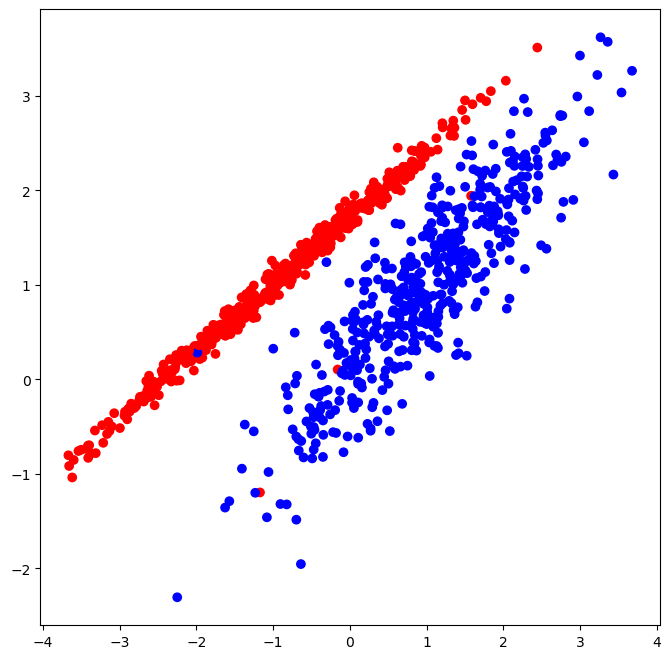

In [20]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors);

In [21]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [22]:
# Визуализируем на графике

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, train_labels, test_data, test_labels, my_forest):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    
    train_accuracy = accuracy_metric(train_labels, tree_vote(my_forest, train_data))
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    
    test_accuracy = accuracy_metric(test_labels, tree_vote(my_forest, test_data))
    plt.title(f'Test accuracy={test_accuracy:.2f}')

Лес из 1 дерева.

In [23]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

Wall time: 160 ms


In [24]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [25]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [26]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 97.714
Точность случайного леса из 1 деревьев на тестовой выборке: 94.667


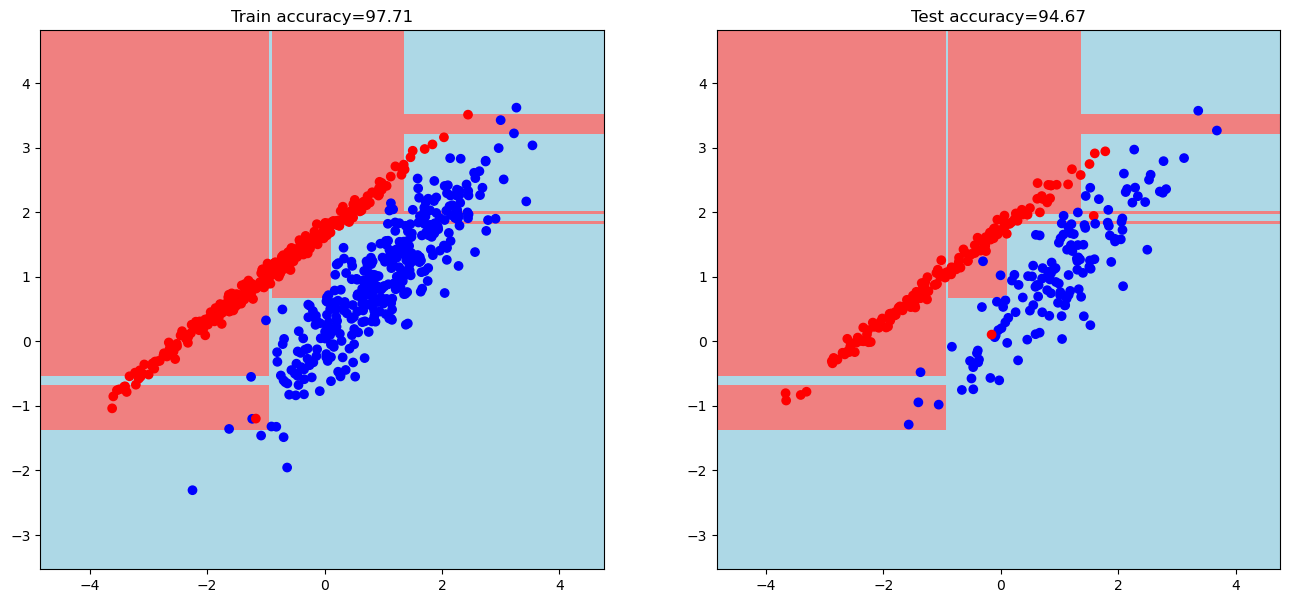

In [27]:
visualize(train_data, train_labels, test_data, test_labels, my_forest_1)

Лес из 3х деревьев

In [28]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

Wall time: 461 ms


In [29]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [30]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [31]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 98.857
Точность случайного леса из 3 деревьев на тестовой выборке: 95.000


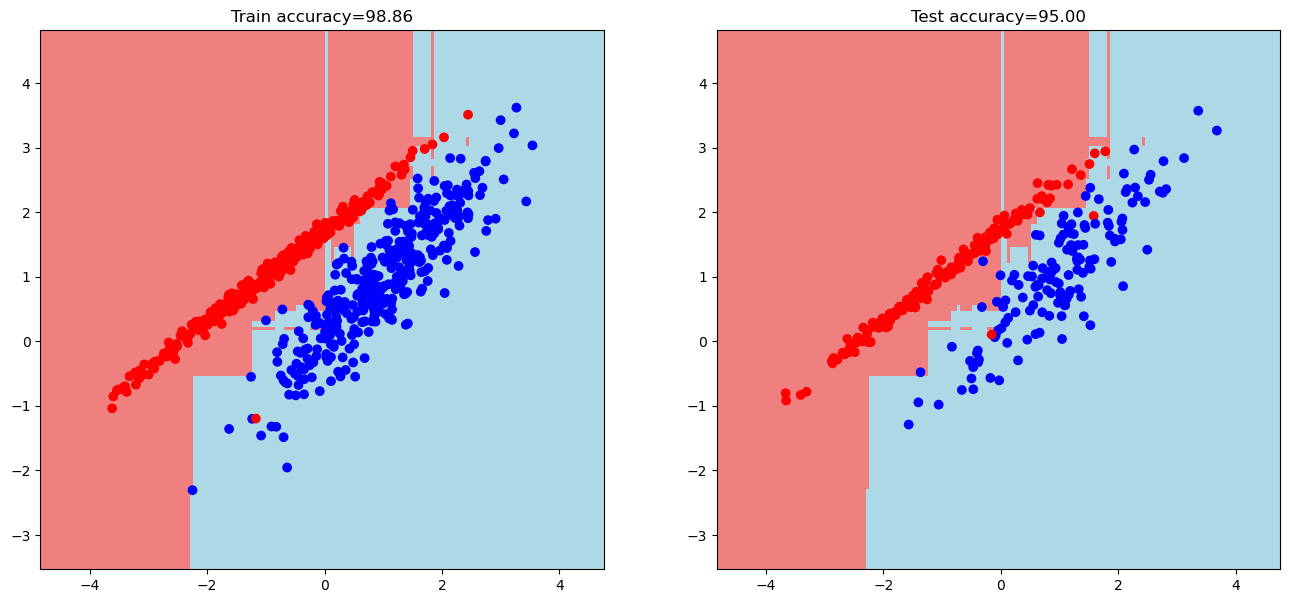

In [32]:
visualize(train_data, train_labels, test_data, test_labels, my_forest_3)

Лес из 10ти деревьев

In [33]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

Wall time: 1.61 s


In [34]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [35]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [36]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 99.571
Точность случайного леса из 10 деревьев на тестовой выборке: 97.000


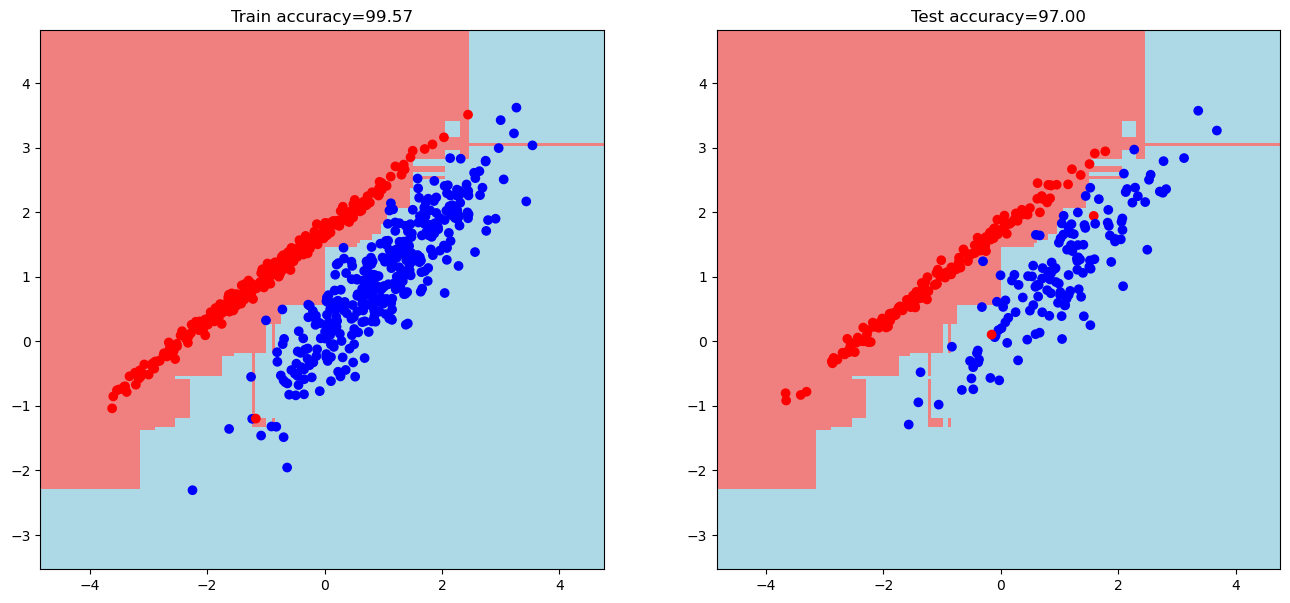

In [37]:
visualize(train_data, train_labels, test_data, test_labels, my_forest_10)

Лес из 50ти деревьев.

In [38]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

Wall time: 12 s


In [39]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [40]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [41]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 98.333


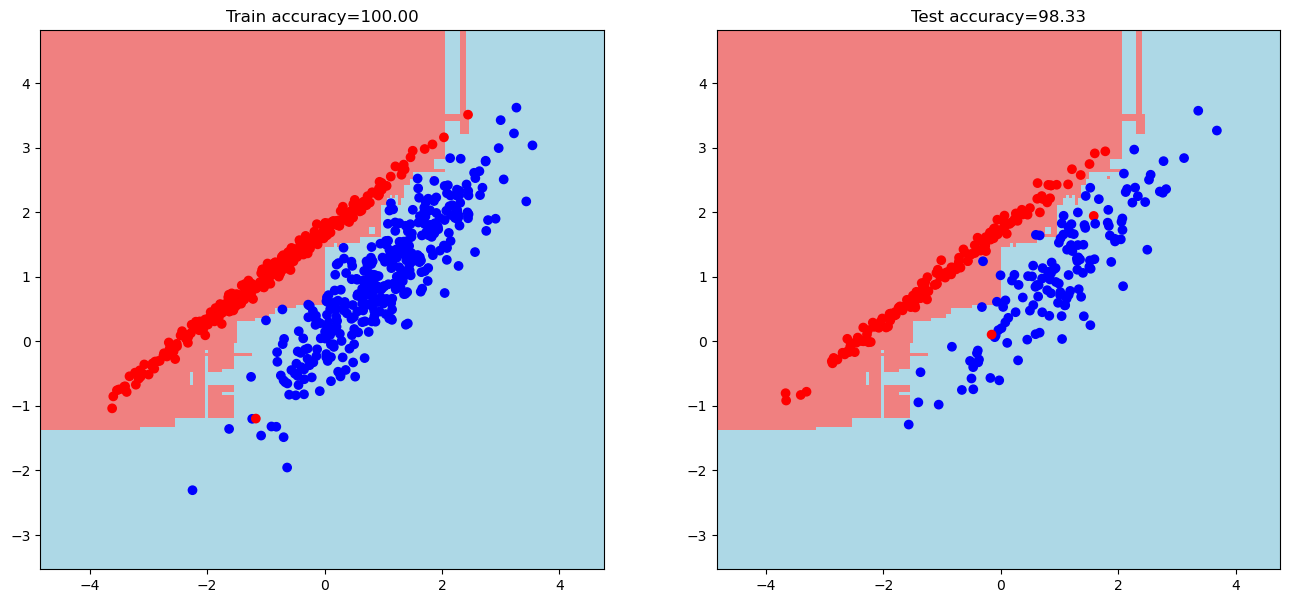

In [42]:
visualize(train_data, train_labels, test_data, test_labels, my_forest_50)

**2) Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.**

Бытует мнение что случайный лес очень сложно переучить, но сложно не говорит что не возможно. На данных в видео уроке при обучении на 50 деревьях появился намек на переобучение, случайный лес показал 100% результат на обучении при этом результат на тесте стал ниже, чем был на обучении на 10-ти деревьях. 
В случае моих данных, переобучение модель не демонстрирует, при увеличении деревьев в ансамбле результат пропорционально растет и на обучающих и на тестовых данных, не демонстрируя перекосов. 
Рост точности логичен при увеличении количества деревьев в ансамбле случайного леса, так как происходит усреднение :
Разброс =  разброс базового алгоритма/𝑁+корреляция между базовыми алгоритмами

**4) *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.**

In [43]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [44]:
# Меняем на энтропию Шэннона
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    for label in classes:
        p = classes[label] / len(labels)
        log2 = np.log2(1/p)
        impurity = p * log2
        
    return impurity
